In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import seaborn as sn
import pandas as pd
import pickle
from collections import defaultdict
from sklearn import metrics
from torch.optim import lr_scheduler
from torchvision import datasets
import os

In [2]:
class GTZANDataset(Dataset):
    def __init__(self, data, transform=None):
        self.data = data
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        x = self.data[idx][0]
        y = self.data[idx][1]
        
        if self.transform:
            x = self.transform(x)
        
        x = torch.Tensor(x)

        return (x, y)

In [3]:
batch_size = 3


transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

GTZAN_data = pickle.load(open('data/GTZAN_resized.train', 'rb'))
trainset = GTZANDataset(GTZAN_data)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=0)

GTZAN_data = pickle.load(open('data/GTZAN_resized.test', 'rb'))
testset = GTZANDataset(GTZAN_data)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                          shuffle=True, num_workers=0)


classes = ('blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock')

In [4]:
# If there are GPUs, choose the first one for computing. Otherwise use CPU.
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)  
# If 'cuda:0' is printed, it means GPU is available.

cuda:0


In [5]:
# https://aip.scitation.org/doi/pdf/10.1063/1.5039095
class cnn(nn.Module):
    def __init__(self):
        super(cnn, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3,padding=1),
            nn.BatchNorm2d(64,momentum=0.1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(64, 64, kernel_size=3,padding=1),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(64, 128, kernel_size=3,padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=3,padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.BatchNorm2d(256),
            nn.Conv2d(256, 512, kernel_size=3,padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(512),
            nn.MaxPool2d(2, 2)       
        )
   
        # flatten 
        self.fc = nn.Sequential(
            nn.Linear(512*2*10,1000),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(1000,100),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(100,10),           
        )
        self.dropOut = nn.Dropout(0.1)
        
    def forward(self, x):

        x = self.main(x)
#         print ('x shape: ', x.shape)
        x = x.view(-1, 512*2*10) 
       
        x = self.fc(x) 
        x = self.dropOut(x)
        return x
        

cnn = cnn()     # Create the network instance.
cnn.to(device)  # Move the network parameters to the specified device.

cnn(
  (main): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU()
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (13): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14):

In [6]:
class Net(nn.Module):  
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=10, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(in_channels=10, out_channels=20, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(20*32*161, 100) # Get the vector of the layer right before the final fc layer and plot tfidf
        self.fc2 = nn.Linear(100, 10) 
        
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 20*32*161)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        
        return x


In [7]:
# net = Net()     # Create the network instance.
# net.to(device)  # Move the network parameters to the specified device.

In [8]:
# We use cross-entropy as loss function.
loss_func = nn.CrossEntropyLoss()  
# We use stochastic gradient descent (SGD) as optimizer.
# opt_net = optim.SGD(net.parameters(), lr=0.001, momentum=0.9) 
opt_cnn = optim.SGD(cnn.parameters(), lr=0.001, momentum=0.9) 

In [9]:
torch.autograd.set_detect_anomaly(True)

In [10]:
avg_losses_cnn = []
avg_acc = []
epochs = 10       # Total epochs.
print_freq = 100  # Print frequency.

try:
    for epoch in range(epochs):  # Loop over the dataset multiple times.
#         running_loss_net = 0.0       # Initialize running loss.
        running_loss_cnn = 0.0 
        running_acc = 0.0
        cnn.train()
#         for i, data in enumerate(trainloader, 0):
        for i, data in enumerate(trainloader):

            # Get the inputs.
            inputs, labels = data

            # Move the inputs to the specified device.
            inputs, labels = inputs.to(device), labels.to(device)

            # Zero the parameter gradients.
#             opt_net.zero_grad()
            opt_cnn.zero_grad()
                    
            outputs_cnn = cnn(inputs)
            _, preds = torch.max(outputs_cnn,1)
            loss_cnn = loss_func(outputs_cnn, labels)

            # Backward step.
            loss_cnn.backward()
            # Optimization step (update the parameters).
            opt_cnn.step()
            # Print statistics.         
            running_loss_cnn += loss_cnn.item()
            running_acc += torch.sum(preds == labels.data)
            if i % print_freq == print_freq - 1: # Print every several mini-batches.

                losses = running_loss_cnn / print_freq
                acc = running_acc / (print_freq*batch_size)

                print('[epoch: {}, i: {:5d}] avg mini-batch loss_cnn: {:.3f}, acc: {:.3f}'.format(
                    epoch, i, losses, acc))

                avg_losses_cnn.append(losses)
                avg_acc.append(acc)

                running_loss_cnn = 0.0
                running_acc = 0.0
    print('Finished Training.')
except KeyboardInterrupt:
    print('Halted Training')

[epoch: 0, i:    99] avg mini-batch loss_cnn: 2.406, acc: 0.157
[epoch: 0, i:   199] avg mini-batch loss_cnn: 2.289, acc: 0.173
[epoch: 1, i:    99] avg mini-batch loss_cnn: 2.220, acc: 0.237
[epoch: 1, i:   199] avg mini-batch loss_cnn: 2.159, acc: 0.253
[epoch: 2, i:    99] avg mini-batch loss_cnn: 2.045, acc: 0.260
[epoch: 2, i:   199] avg mini-batch loss_cnn: 2.176, acc: 0.213
[epoch: 3, i:    99] avg mini-batch loss_cnn: 1.992, acc: 0.293
[epoch: 3, i:   199] avg mini-batch loss_cnn: 1.991, acc: 0.290
[epoch: 4, i:    99] avg mini-batch loss_cnn: 2.093, acc: 0.267
[epoch: 4, i:   199] avg mini-batch loss_cnn: 2.062, acc: 0.257
[epoch: 5, i:    99] avg mini-batch loss_cnn: 1.939, acc: 0.293
[epoch: 5, i:   199] avg mini-batch loss_cnn: 1.993, acc: 0.333
[epoch: 6, i:    99] avg mini-batch loss_cnn: 2.010, acc: 0.290
[epoch: 6, i:   199] avg mini-batch loss_cnn: 1.891, acc: 0.300
[epoch: 7, i:    99] avg mini-batch loss_cnn: 1.820, acc: 0.363
[epoch: 7, i:   199] avg mini-batch loss

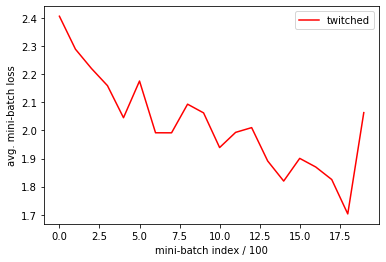

In [11]:
# plt.plot(avg_losses_net, 'b', label='default')
plt.plot(avg_losses_cnn, 'r', label='twitched')
plt.xlabel('mini-batch index / {}'.format(print_freq))
plt.ylabel('avg. mini-batch loss')
plt.legend()
plt.show()

In [12]:
# Get test accuracy.
correct_net = 0
correct_cnn = 0
total = 0
with torch.no_grad():
    
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
#         outputs_net = net(images)
        outputs_cnn = cnn(images)
#         _, predicted_net = torch.max(outputs_net.data, 1)
        _, predicted_cnn = torch.max(outputs_cnn.data, 1)
        total += labels.size(0)
#         correct_net += (predicted_net == labels).sum().item()
        correct_cnn += (predicted_cnn == labels).sum().item()

# print('Net: Accuracy of the network on the 10000 test images: %d %%' % (
#     100 * correct_net / total))
print('Cnn: Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct_cnn / total))

Cnn: Accuracy of the network on the 10000 test images: 30 %


In [28]:
truths = []

# Get test accuracy for each class.
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        if type(c) is not list:
            c = [c]
        for i in range(batch_size):
            preds.append(predicted[i].item())
            truths.append(labels[i].item())
            confusion_matrix[actual][pred] += 1
            
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

tensor(True, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
0


IndexError: list index out of range

In [ ]:
array = metrics.confusion_matrix(truths, preds_net)
df_cm = pd.DataFrame(array, index = classes, columns = classes)
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True)

In [ ]:
array = metrics.confusion_matrix(truths, preds_cnn)
df_cm = pd.DataFrame(array, index = classes, columns = classes)
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True)